In [29]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.optimize as so

# Class for our camera model
class Camera(object):
    def __init__(self):
        self.p = None                   # Pose
        self.f = None                   # Focal Length in Pixels
        self.c = np.array([None,None])  # Sensor
        
    def projective_transform(self,x):
        """  
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        """
        focal = self.f
        sensor = self.c
        
        #General Coordinates
        gcx = x[0]/x[2]
        gcy = x[1]/x[2]
        
        #Pixel Locations
        pu = gcx*focal + sensor[0]/2.
        pv = gcy*focal + sensor[1]/2.
        
        return np.array([pu,pv])
      
    
    def rotational_transform(self,X,pts):
        """  
        This function performs the translation and rotation from world coordinates into generalized camera coordinates.
        """
        
        cam_x = X[0]
        cam_y = X[1]
        cam_z = X[2]
        roll = X[3]
        pitch = X[4]
        yaw = X[5]
        
        r_axis = np.array([[1, 0, 0], [0, 0,-1], [0, 1, 0]])
        r_roll = np.array([[np.cos(roll), 0, -1*np.sin(roll)], [0, 1, 0], [np.sin(roll), 0, np.cos(roll)]])
        r_pitch = np.array([[1, 0, 0], [0, np.cos(pitch), np.sin(pitch)], [0, -1*np.sin(pitch), np.cos(pitch)]])
        r_yaw = np.array([[np.cos(yaw), -1*np.sin(yaw), 0, 0], [np.sin(yaw), np.cos(yaw), 0, 0], [0, 0, 1, 0]])

        T = np.array([[1, 0, 0, -cam_x],[0, 1, 0, -cam_y], [0, 0, 1, -cam_z], [0, 0, 0, 1]])
        
        C = r_axis @ r_roll @ r_pitch @ r_yaw @ T

        return C @ pts
    
    def estimate_pose(self,gcps):
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp 
        and the projected pixels coordinates of X_gcp is minimized.
        """
        p_opts = [] # Initial easting, northing, elevation positions
        u_gcps = [] # Initial projected u,v coordinates

        for gcp in gcps:
            pts = gcp[2:5]
            # Add homogenous coordinate
            pts.append(1)

            # Observed pixel coordinates
            u_gcp = gcp[0:2]
            p_opts.append(pts)
            u_gcps.append(u_gcp)
    
        ave_easting = np.mean([gcp[2] for gcp in gcps])
        ave_northing = np.mean([gcp[3] for gcp in gcps])
        ave_elevation = np.mean([gcp[4] for gcp in gcps])
            
        # Initial guess at the pose
        p0 = np.array([ave_easting, ave_northing, ave_elevation,90,45,45])
        
        # print(p0, '\n', p_opts, '\n', u_gcps, '\n')
        
        # Find the optimal pose minimizing the residual
        p_opt = so.least_squares(self.residual, p0, method='lm', args=(p_opts,u_gcps))['x']
        
        self.p = p_opt
        
    # Function to transform all gcps into the camera coordinates
    def transform_all(self,X_gcp, p):
        transformed = []
        
        for gcp in X_gcp:
            # Perform rotational transform on X_gcp
            rotated = self.rotational_transform(p, gcp)
            
            # Project the rotated coordinates to pixel coordinates
            projected = self.projective_transform(rotated)
            transformed.append(projected)

        return transformed
    
    # Calculate the difference in the estimate projection of X_gcp and actual positions of u_gcp
    def residual(self, p0, X_gcp, u_gcp):
        all_res = np.array(self.transform_all(X_gcp, p0)) - np.array(u_gcp)
        all_res = all_res.ravel()
        
        return all_res

In [30]:
# Initialize the camera and it's attributes from .exif file
myCam = Camera()

myCam.f = (28/36)*4032 # Focal length
myCam.c = np.array([4032.,3024.]) # Sensor size

# List to hold the gcp info
gcps = []

# Read in gcp's from file
f = open('image_coordinates.txt', 'r')
for line in f:
    # Remove newline characters
    line = line.replace("\n", "")
    
    # Delimit by comma
    line = line.split(',')
    
    # Convert string array to floats
    for x in range(0,len(line)-1):
        line[x] = float(line[x])
    
    # Add the single gcp
    gcps.append(line)
    
# Calculate the pose
myCam.estimate_pose(gcps)

print("Optimal Pose: ", myCam.p)

Optimal Pose:  [3.22967716e+05 4.30648876e+06 1.25055534e+01 8.80759069e+01
 4.40193413e+01 4.55108445e+01]


Easting:  322967.71563706093
Northing:  4306488.762752261
Elevation:  12.505553401696146
Roll:  88.07590688357206
Pitch:  44.01934125637955
Yaw:  45.5108445236733


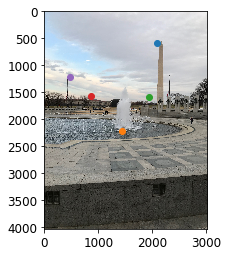

In [31]:
# Check the pose to see how it projects our gcps
final_coords = []

pts = []
pt = []
for gcp in gcps:
    pt = gcp[2:5]
    pt.append(1)
    pts.append(pt)

final_coords = myCam.transform_all(pts, myCam.p)

# Plot the GCP's using optimally estimated pose.
plt.rcParams.update({'font.size': 12})
for x in range(0,len(final_coords)):
#     plt.scatter(u_gcps[x][0], u_gcps[x][1], marker="x")
    #plt.text(final_coords[x][0], final_coords[x][1], "gcp" + str((x)))
    plt.scatter(final_coords[x][0], final_coords[x][1])
im = plt.imread('national_mall.jpg')
implot = plt.imshow(im)

print("Easting: ", myCam.p[0])
print("Northing: ", myCam.p[1])
print("Elevation: ", myCam.p[2])
print("Roll: ", myCam.p[3])
print("Pitch: ", myCam.p[4])
print("Yaw: ", myCam.p[5])